# Validating and Inspecting Time Series Models
  
Once you've got a model for predicting time series data, you need to decide if it's a good or a bad model. This chapter coves the basics of generating predictions with models in order to validate them against "test" data.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
# plt.style.use('fivethirtyeight')
plt.rcParams['image.cmap'] = 'inferno'

[Matplotlib Style Sheet Ref](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

## Time-delayed features and auto-regressive models
  
One of the most important steps in a machine learning pipeline is feature extraction. Defining high-quality and relevant features gives your model the best chance at finding useful patterns in the data. In this lesson, we'll cover some techniques for extracting features from data.
  
**The past is useful**
  
Perhaps the biggest difference between timeseries data and "non-timeseries" data is the relationship between data points. Because the data has a linear flow (matching the progression of time), patterns will persist over a span of datapoints. As a result, we can use information from the past in order to predict values in the future.
  
**A note on smoothness and auto-correlation**
  
It's important to consider how "smooth" your data is when fitting models with timeseries. The smoothness of your data reflects how much correlation there is between one time point and those that come before and after it. The extent to which previous timepoints are predictive of subsequent timepoints is often described as "autocorrelation", and can have a big impact on the performance of your model.
  
**Creating time-lagged features**
  
Let's investigate this by creating a model in which previous timepoints are used as input features to the model. Remember that regression models will assign a "weight" to each input feature, and we can use these weights to determine how "smooth" or "autocorrelated" the signal is.
  
**Time-shifting data with Pandas**
  
First we'll create time-shifted versions of our data. This entails "rolling" your data either into the future or into the past, so that the same index of data now has an different timepoint in it. We can do this in Pandas by using the `pd.shift()` method of a DataFrame. Positive values roll the data backward, while negative values roll the data forward.
  
<img src='../_images/time-shifting-data-with-pandas.png' Alt Text='Alt Text' width='740'>
  
**Creating a time-shifted DataFrame**
  
Here we use a dictionary comprehension that creates several time-lagged versions of the data. Each one shifts the data a different number of indices into the past. Since our data is recorded daily, this corresponds to shifting the data so that each index corresponds to the value of the data N days prior. We can then convert this into a DataFrame where dictionary keys become column names.
  
<img src='../_images/creating-a-time-shifted-dataframe.png' Alt Text='Alt Text' width='740'>
  
**Fitting a model with time-shifted features**
  
We will now fit a scikit-learn regression model. Note that in this case, "many_shifts" is simply a time-shifted version of the timeseries contained in the "data" variable. We'll fit the model using Ridge regression, which spreads out weights across features (if applicable) rather than assign it all to a single feature.
  
```
# Fit the model using these imput feature
model = Ridge()
model.fit(many_shifts, data)
```
  
**Interpreting the auto-regressive model coefficients**
  
Once we fit the model, we can investigate the coefficients it has found. Larger absolute values of coefficients mean that a given feature has a large impact on the output variable. We can use a bar plot in Matplotlib to visualize the model's coefficients that were created after fitting the model.
  
<img src='../_images/interpreting-the-auto-regressive-model-coefficients.png' Alt Text='Alt Text' width='740'>

**Visualizing coefficients for a rough signal**
  
Here we see the coefficient values for a relatively non-smooth signal. On the left the signal is clearly jumping around, and on the right we see the model coefficients (one per time lag) drop to zero very quickly.
  
<img src='../_images/visualizing-coefficients-for-a-rough-signal.png' Alt Text='Alt Text' width='740'>

**Visualizing coefficients for a smooth signal**
  
And here is a timeseries that is more smooth. On the left we can see more "structure" to the data, and on the right we see that the coefficients for time lags drop off to zero smoothly.
  
<img src='../_images/visualizing-coefficients-for-a-rough-signal2.png' Alt Text='Alt Text' width='740'>

### Creating time-shifted features
  
In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.
  
In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.
  
1. Use a dictionary comprehension to create multiple time-shifted versions of prices_perc using the lags specified in shifts.
2. Convert the result into a DataFrame.
3. Use the given code to visualize the results.

In [28]:
# Loading the required dataset
prices = pd.read_csv('../_datasets/prices_nyse.csv', index_col=0, parse_dates=True)

# This is the function from chapter 3, just copy and pasted here
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]
    
    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the difference that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median across the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)

# Apply your preprocessing functino to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)

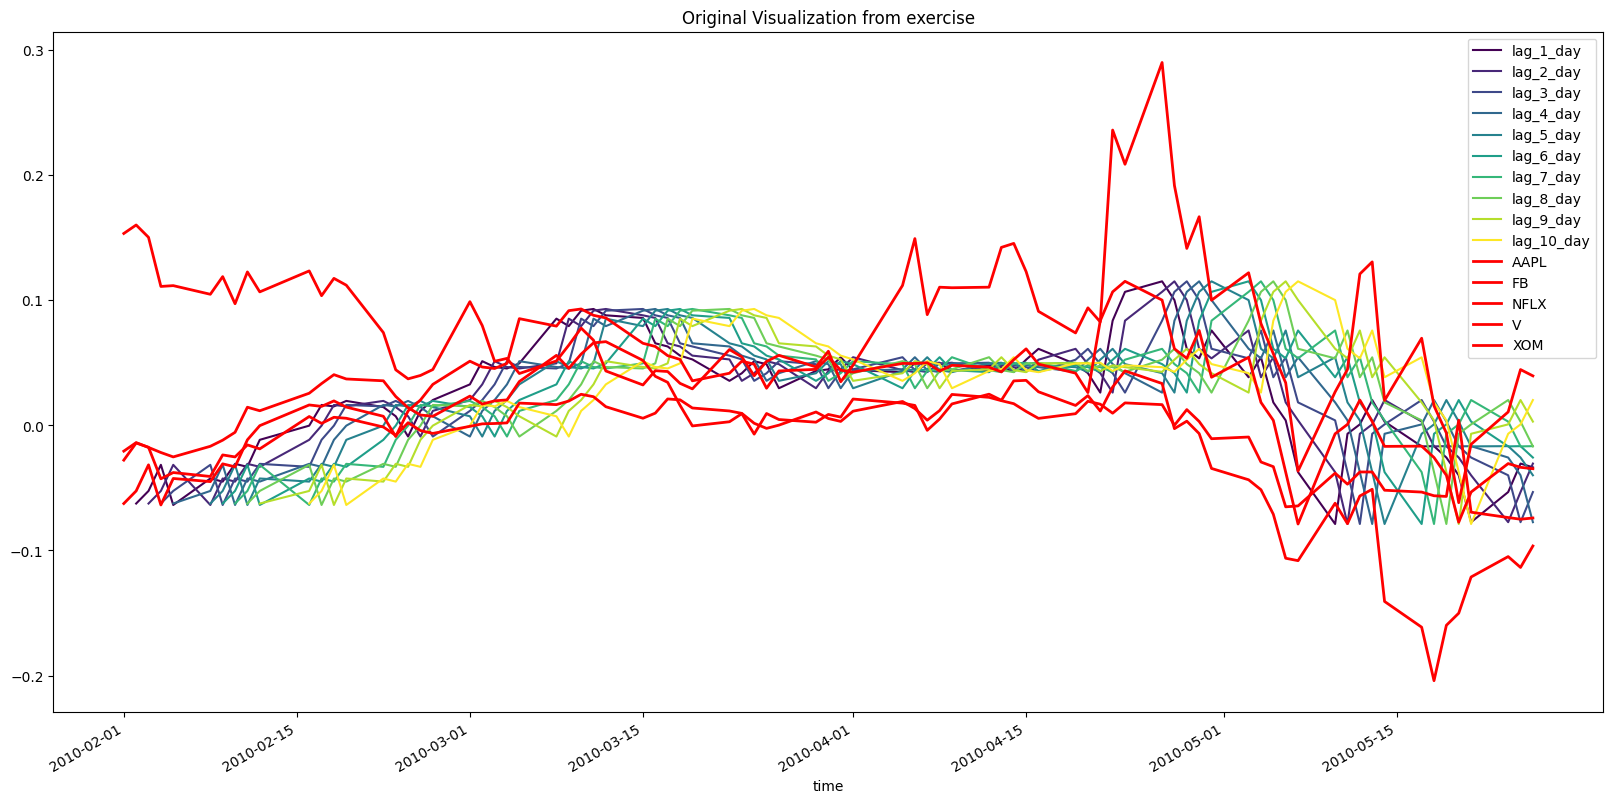

In [29]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): 
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(20, 10))
prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis, ax=ax)
prices_perc.iloc[:100].plot(color='r', lw=2, ax=ax)
ax.legend(loc='best')
plt.title('Original Visualization from exercise')
plt.show()

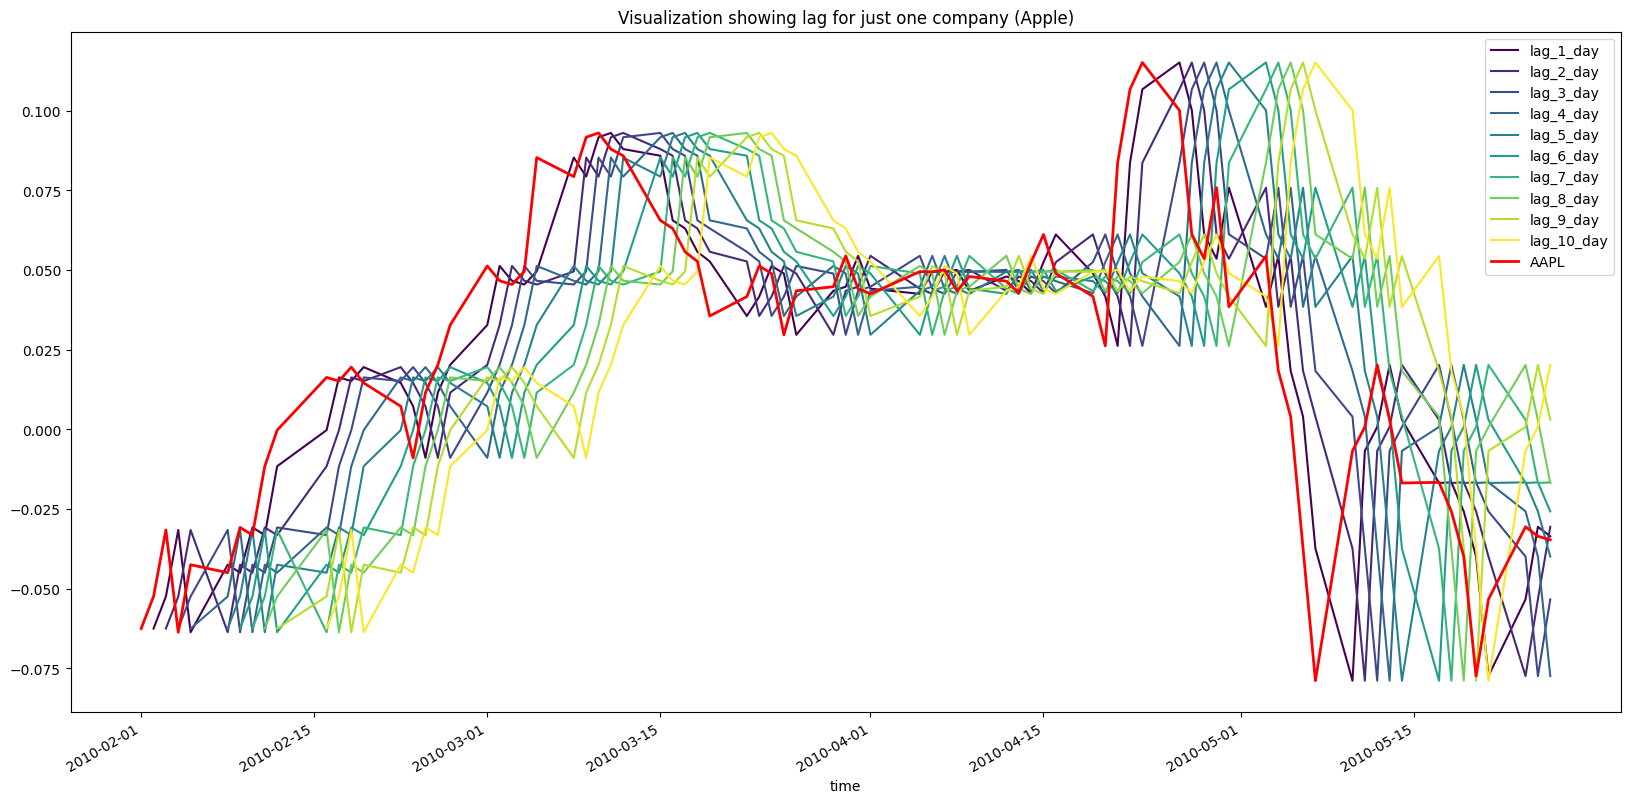

In [30]:
# Subsetting for easier view
prices = prices[['AAPL']]

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)

# Apply your preprocessing functino to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)

# These are the "time-lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): 
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(20, 10))
prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis, ax=ax)
prices_perc.iloc[:100].plot(color='r', lw=2, ax=ax)
ax.legend(loc='best')
plt.title('Visualization showing lag for just one company (Apple)')
plt.show()

Great job!

### Special case: Auto-regressive models
  
Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).
  
By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.
  
1. Replace missing values in prices_perc_shifted with the median of the DataFrame and assign it to X.
2. Replace missing values in prices_perc with the median of the series and assign it to y.
3. Fit a regression model using the X and y arrays.

In [31]:
from sklearn.linear_model import Ridge


# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

You've filled in the missing values with the median so that it behaves well with scikit-learn. Now let's take a look at what your model found.

### Visualize regression coefficients
  
Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.
  
The shifted time series DataFrame (prices_perc_shifted) and the regression model (model) are available in your workspace.
  
In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.
  
1. Define a function (called visualize_coefficients) that takes as input an array of coefficients, an array of each coefficient's name, and an instance of a Matplotlib axis object. It should then generate a bar plot for the input coefficients, with their names on the x-axis.
2. Use this function (`visualize_coefficients()`) with the coefficients contained in the model variable and column names of prices_perc_shifted.

In [32]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # setting the formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    return ax

<Axes: xlabel='Coefficient name', ylabel='Coefficient value'>

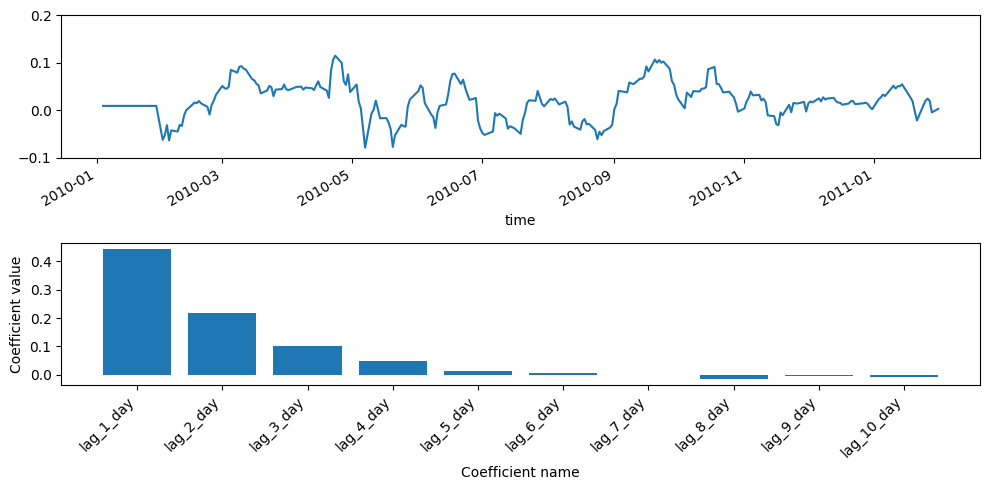

In [33]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0], ylim=(-0.1, 0.2))

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])

When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the $Nth -1$ time point is useful in predicting the $Nth$ timepoint, but no other points are useful.

### Auto-regression with a smoother time series
  
Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?
  
prices_perc_shifted and model (updated to use a window of 40) are available in your workspace.
  
1. Using the function (`visualize_coefficients()`) you created in the last exercise, generate a plot with coefficients of model and column names of prices_perc_shifted.

In [34]:
# Apply your custom function and plot
prices_perc = prices.rolling(40).apply(percent_change)

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): 
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

<Axes: xlabel='Coefficient name', ylabel='Coefficient value'>

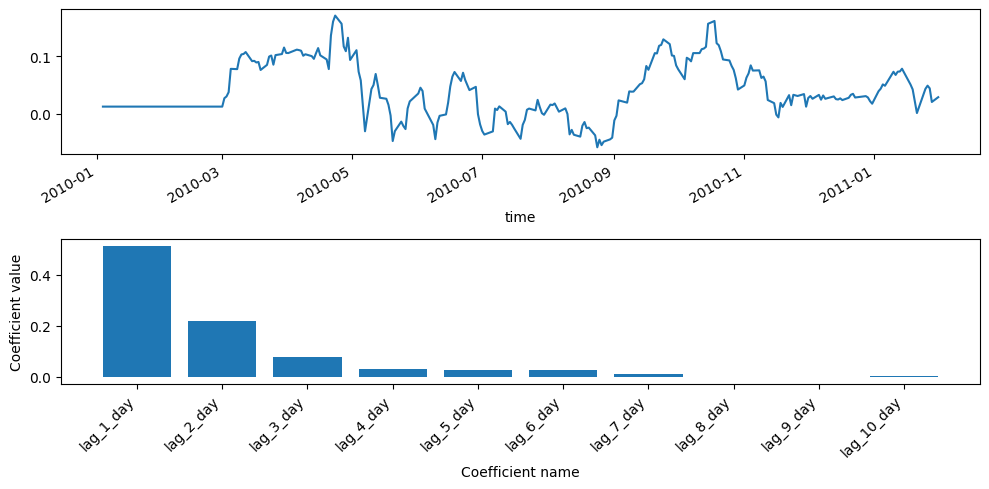

In [35]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:"2011-01"].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])

As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d (Independent and Identically Distributed).
  
NOTE: In probability theory and statistics, a collection of random variables is independent and identically distributed if each random variable has the same probability distribution as the others and all are mutually independent. This property is usually abbreviated as i.i.d., iid, or IID.

## Cross-validating timeseries data
  
We'll now discuss some of the basics of cross-validation, as well as how they relate to fitting timeseries data.
  
**Cross validation with scikit-learn**
  
Scikit-learn has many classes for cross-validation. For reference, here is the standard way to use each one of them.
  
<img src='../_images/cross-validation-with-scikit-learn-stardard.png' Alt Text='Alt Text' width='740'>
  
**Cross validation types: KFold**
  
The most common form of cross-validation is k-fold cross-validation. In this case, data is split into K subsets of equal size. In each iteration, a single subset is left out as the validation set. Here we show how to initialize a k-fold iterator with scikit-learn.
  
<img src='../_images/cross-validation-type-kfold.png' Alt Text='Alt Text' width='740'>

**Visualizing model predictions**
  
Always visualize your model's behavior during cross-validation. Here, we first show how to plot the indices of the validation set for each iteration. Next, we visualize the predictions generated in this loop. This helps us perform sanity checks on the process.
  
<img src='../_images/visualizing-model-predictions-kfold-cross-validation.png' Alt Text='Alt Text' width='740'>
  
**Visualizing KFold CV behavior**
  
Looking at the generated plot, we first see that the validation indices are chunked in "blocks" or "folds". This is the default cross-validation behavior. On the bottom we see three timeseries that were predicted, one for each iteration. They have the same general structure as time series data, which is a good sanity check.
  
<img src='../_images/visualizing-kfold-cross-validation-behavior.png' Alt Text='Alt Text' width='740'>

**A note on shuffling your data**
  
Many cross-validation iterators let you randomly shuffle the data. This may be appropriate if your data is *independent and identically distributed*, but timeseries data is usually not i.i.d. Here we use the "ShuffleSplit" cross-validation iterator, which randomly permutes the data labels in each iteration. Let's see what our visualization looks like when using shuffled data.
  
<img src='../_images/a-note-on-shuffling-your-data.png' Alt Text='Alt Text' width='740'>

**Visualizing shuffled CV behavior**
  
Here we can see from the top plot that the validation indices are all over the place, not in chunks like before. That's because we used a cross-validation object that shuffles the data. Below we see that the output data no longer "looks" like timeseries, because the temporal structure of the data has been destroyed. If the data is shuffled, it means that some information about the training set now exists in the validation set, and you can no longer trust the score of your model.
  
<img src='../_images/visualizing-shuffled-cv-behavior-on-time-series.png' Alt Text='Alt Text' width='740'>
  
**Using the time series CV iterator**
  
Finally, we'll cover another cross-validation iterator that can help deal with these problems. There is one cross-validation technique that is meant particularly for time series data. This approach *always* uses data from the past to predict timepoints in the future. Through CV iterations, a larger amount of training data is used to predict the next block of validation data, corresponding to the fact that more time has passed. This more closely mimics the data collection and prediction process in the real world.
  
**Visualizing time series cross validation iterators**
  
We can use this cross-validation approach with the `TimeSeriesSplit()` object in scikit-learn. Here we iterate through the object and plot the training data in blue and the validation data in red. Let's visualize this behavior.
  
<img src='../_images/visualizing-time-series-cross-validation-time-series-split.png' Alt Text='Alt Text' width='740'>
  
**Visualizing the TimeSeriesSplit cross validation iterator**
  
Here we see how the `TimeSeriesSplit` CV object behaves. Each row is an iteration of the cross validation. In red we see the validation indices for that iteration. As you can see, the training data always comes before the validation data. This ensures that only the past is always used to predict the future.
  
<img src='../_images/visualizing-time-series-cross-validation-time-series-split1.png' Alt Text='Alt Text' width='740'>
  
**Custom scoring functions in scikit-learn**
  
You can also create custom scorers in scikit-learn. They must all take an estimator object, and X and y arrays as inputs, and output a single number, representing the score calculated after generating model predictions. You can use whatever function you like to create this score.
  
<img src='../_images/custom-scoring-functions-in-scikit-learn.png' Alt Text='Alt Text' width='740'>
  
**A custom correlation function for scikit-learn**
  
Here we define our custom correlation function for scikit-learn. It generates model predictions, then uses numpy's `corrcoef()` function to output a correlation matrix. We take a single value from this matrix, since there are only two variables in it, and return the value.
  
<img src='../_images/custom-correlation-function-for-scikit-learn.png' Alt Text='Alt Text' width='740'>

### Cross-validation with shuffling
  
As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a different training and test set. In this exercise, you'll perform a traditional `ShuffleSplit` cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.
  
An instance of the Linear regression object (model) is available in your workspace along with the function `r2_score()` for scoring. Also, the data is stored in arrays X and y. We've also provided a helper function (`visualize_predictions()`) to help visualize the results.
  
1. Initialize a ShuffleSplit cross-validation object with 10 splits.
2. Iterate through CV splits using this object. On each iteration:
3. Fit a model using the training indices.
4. Generate predictions using the test indices, score the model ($R^2$) using the predictions, and collect the results.

In [36]:
# Loading the data as NumPy arrays
X = pd.read_csv('../_datasets/stock_10x.csv', index_col=0).to_numpy()
y = pd.read_csv('../_datasets/stock_10y.csv', index_col=0).to_numpy()

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Model Instantiation
model = LinearRegression()

In [38]:
# Creating the required function for the exercise
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, 
                       label='Iteration {}'.format(ii))

        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")

NOTE: `tr` $\equiv$ train, `tt` $\equiv$ test

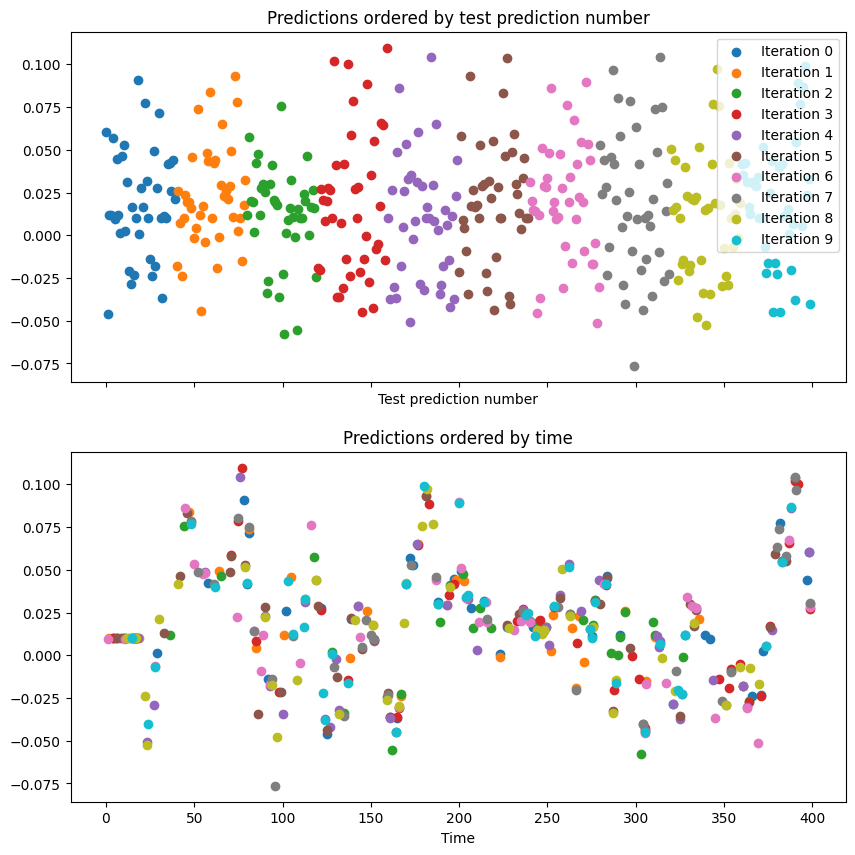

In [39]:
from sklearn.model_selection import ShuffleSplit


# Creating the ShuffleSplit object with 10 splits and in SEED 1
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

You've correctly constructed and fit the model. If you look at the plot, see that the order of datapoints in the test set is scrambled. Let's see how it looks when we shuffle the data in blocks.

### Cross-validation without shuffling
  
Now, re-run your model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?
  
An instance of the Linear regression model object is available in your workspace. Also, the arrays X and y (training data) are available too.
  
1. Instantiate another cross-validation object, this time using `KFold()` cross-validation with 10 splits and no shuffling.
2. Iterate through this object to fit a model using the training indices and generate predictions using the test indices.
3. Visualize the predictions across CV splits using the helper function (`visualize_predictions()`) we've provided.

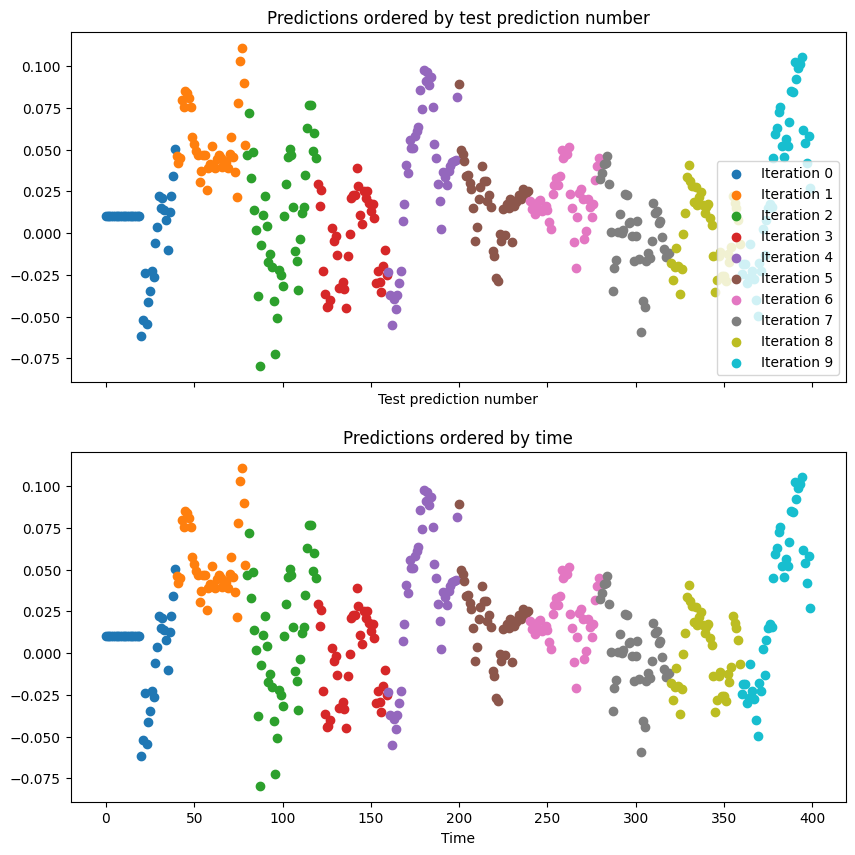

In [40]:
from sklearn.model_selection import KFold


# Create KFold cross-validation object
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, _, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.

### Time-based cross-validation
  
Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. Use this object to iterate through your data one last time, visualizing the training data used to fit the model on each iteration.
  
An instance of the Linear regression model object is available in your workpsace. Also, the arrays X and y (training data) are available too.
  
1. Import `TimeSeriesSplit` from `sklearn.model_selection`.
2. Instantiate a time series cross-validation iterator with 10 splits.
3. Iterate through CV splits. On each iteration, visualize the values of the input data that would be used to train the model for that iteration.

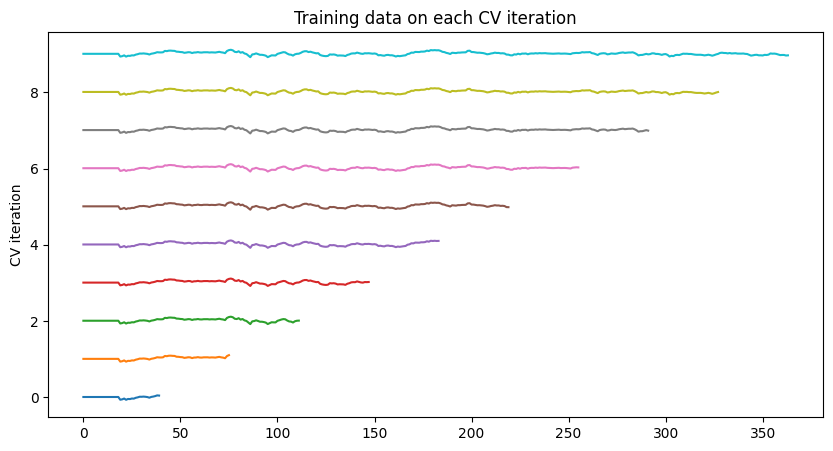

In [41]:
from sklearn.model_selection import TimeSeriesSplit


# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])
    
ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always after the timepoints we train on.

## Stationarity and stability
  
In this lesson, we'll cover how to quantify variability in our models and how this relates to time series data.
  
**Stationarity**
  
A stationary signal is one that does not change its statistical properties over time. It has the same mean, standard deviation, and general trends. A non-stationary signal does change its properties over time. Each of these has important implications for how to fit your model.
  
**Examples of stationary and non-stationary data**
  
Here's an example of a stationary and a non-stationary signal. On the top, we can see that the signal generally does not change its structure. Its variability is constant throughout time. On the bottom, we see a signal that is highly non-stationary. Its variance and trends change over time. Almost all real world data are non-stationary. In fact, these two plots are of the same data, but in different ranges of time.
  
<img src='../_images/example-of-stationary-and-non-stationary-signal.png' width='740'>
  
**Model stability**
  
Most models have an implicit assumption that the relationship between inputs and outputs is static. If this relationship changes (because the data is not stationary), then the model will generate predictions using an outdated relationship between inputs and outputs. How can we quantify and correct for this?
  
**Cross validation to quantify parameter stability**
  
One approach is to use cross-validation, which yields a set of model coefficients per iteration. We can quantify the variability of these coefficients across iterations. If a model's coefficients vary widely between cross-validation splits, there's a good chance the data is non-stationary (or noisy).
  
**Bootstrapping the mean**
  
Bootstrapping is a way to estimate the confidence in the mean of a collection of numbers. To perform a bootstrap for the mean, take many random samples (with replacement) from your collection of numbers and calculate the mean of each. Now, calculate lower/upper percentiles for this list. The lower and upper percentiles represent the variability of the mean.
  
**Bootstrapping the mean**
  
Here's an example using scikit-learn and numpy. Use the resample function in scikit-learn to take a random sample of coefficients, then use numpy to calculate the mean for each coefficient in the sample and store it in an array. Then, we calculate the 2.5 and 97.5 percentile of the results to calculate lower and upper bounds for each coefficient. This is called a 95% confidence interval.
  
<img src='../_images/example-bootstrapping-the-mean-sklearn-numpy.png' width='740'>
  
**Plotting the bootstrapped coefficients**
  
Here we plot the lower and upper bounds of the 95% confidence intervals we calculated. This gives us an idea for the variability of the mean across all cross-validation iterations.
  
<img src='../_images/plotting-the-bootstrapped-confidence-intervals.png' width='740'>
  
**Assessing model performance stability**
  
It's also common to quantify the stability of a model's predictive power across cross-validation folds. If you're using the `TimeSeriesSplit` object mentioned before, then you can visualize this as a timeseries.
  
**Model performance over time**
  
In this example, we'll use the `cross_val_score()` function, along with the `TimeSeriesSplit()` iterator, to calculate the predictive power of the model over cross-validation splits. We first create a small scoring function that can be passed to `cross_val_score()`. Next we use a list comprehension to find the date of the beginning of each validation block. Finally, we collect the scores and convert them into a Pandas Series.
  
<img src='../_images/model-preformance-over-time-cross-val-score-time-series-split.png' width='740'>
  
**Visualizing model scores as a timeseries**
  
Because the cross-validation splits happen linearly over time, we can visualize the results as a timeseries. If we see large changes in the predictive power of a model at one moment in time, it could be because the statistics of the data have changed. Here we create a rolling mean of our cross-validation scores and plot it with matplotlib.
  
<img src='../_images/visualizing-model-scores-as-a-timeseries-cv-splits-linearly.png' width='740'>
  
**Visualizing model scores**
  
We can see the scores of our model across validation sets, which means over time. There is a clear dip in the middle, probably because the statistics of the data changed. What can we do about this?
  
<img src='../_images/visualizing-model-scores-as-a-timeseries-cv-splits-linearly1.png' width='740'>
  
**Fixed windows with time series cross-validation**
  
One option is to restrict the size of the training window. This ensures that only the latest datapoints are used in training. We can control this with the `max_train_size=` parameter.
  
<img src='../_images/fixed-windows-with-time-series-cv-restrict-window.png' width='740'>
  
**Non-stationary signals**
  
Re-visiting our visualization from before, we see that restricting the training window slightly improves the dip in performance in the middle of our validation data.
  
<img src='../_images/fixed-windows-with-time-series-cv-restrict-window1.png' width='740'>
  

### Question
  
<img src='../_images/stationary-question-answer-ts.png' width='860'>
  
**Possible Answers**
  
- [ ] C only

- [ ] D and C
  
- [ ] B only
  
- [x] B and C
  
Correct! C begins to trend upward partway through, while B shows a large increase in variance mid-way through, making both of them non-stationary.

### Bootstrapping a confidence interval
  
A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.
  
This function takes three parameters: a 2-D array of numbers (data), a list of percentiles to calculate (percentiles), and the number of boostrap iterations to use (n_boots). It uses the resample function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.
  
1. The function should loop over the number of bootstraps (given by the parameter n_boots) and take a random sample of the data, with replacement, and calculate the mean of this random sample
2. Compute the percentiles of bootstrap_means and return it

In [42]:
from sklearn.utils import resample


def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    
    # Convert 1-dimensional data to 2-dimensional if necessary
    if data.ndim == 1:
        data = data[:, np.newaxis]  # Add a new axis
        data = np.atleast_2d(data)  # Ensure it is at least 2-dimensional
        
    # Create an empty array to store bootstrap means
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    
    # Perform bootstrap iterations
    for ii in range(n_boots):
        # Generate random sample with replacement
        random_sample = resample(data)
        
        # Calculate mean of the random sample
        bootstrap_means[ii] = random_sample.mean(axis=0)
    
    # Calculate percentiles of the bootstrap means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    
    # Return the calculated percentiles as the confidence interval
    return percentiles


You can use this function to assess the variability of your model coefficients.

### Calculating variability in model coefficients
  
In this lesson, you'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.
  
Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data.
  
An instance of the Linear regression object (model) is available in your workpsace. Also, the arrays X and y (the data) are available too.
  
1. Initialize a `TimeSeriesSplit` cross-validation object
2. Create an array of all zeros to collect the coefficients.
3. Iterate through splits of the cross-validation object. On each iteration:
4. Fit the model on training data
5. Collect the model's coefficients for analysis later
6. Finally, calculate the 95% confidence interval for each coefficient in coefficients using the `bootstrap_interval()` function you defined in the previous exercise. You can run bootstrap_interval, if you want a refresher on the parameters that this function takes.

In [43]:
# Loading the dataset as NumPy arrays
y = pd.read_csv('../_datasets/stock_12y.csv', index_col=0).to_numpy()
X = pd.read_csv('../_datasets/stock_12x.csv', index_col=0).to_numpy()

# Writing the feature names 
feature_names = np.array(['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
       'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
       'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day'])

# Writing the Index's as datatimes
times_scores = pd.DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
               '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
               '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
               '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
               '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
               '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
               '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
               '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
               '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
               '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
               '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
               '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'], name='date')

# Instantiating the Linear Regression object
model = LinearRegression()

In [44]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits)

# Creating an empty array of 0 0 0's to collect coefficients, seeding the global variable for the for-loop
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

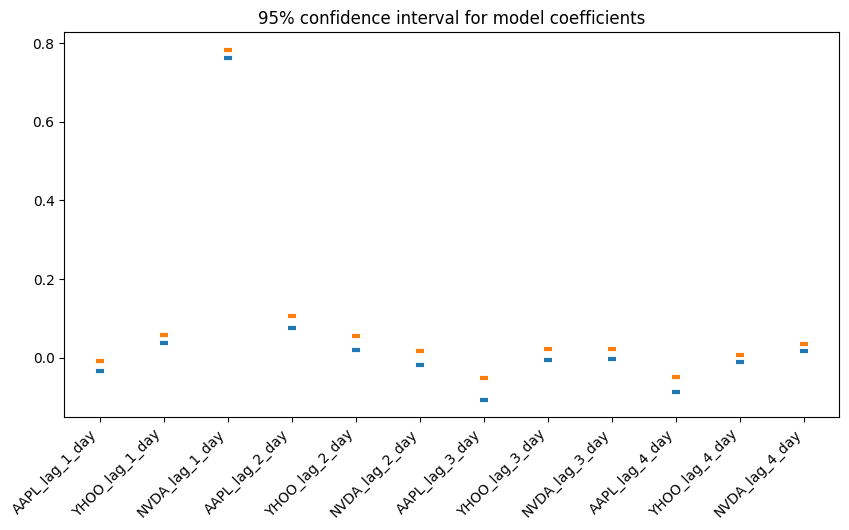

In [45]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title=r'95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

You've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time!

### Visualizing model score variability over time
  
Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the `TimeSeriesSplit` object will use successively-later indices for each test set. This means that you can treat the scores of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.
  
An instance of the Linear regression model object is stored in model, a cross-validation object in cv, and data in X and y.
  
1. Calculate the cross-validated scores of the model on the data (using a custom scorer we defined for you, `my_pearsonr` along with `cross_val_score()`).
2. Convert the output scores into a pandas Series so that you can treat it as a time series.
3. Bootstrap a rolling confidence interval for the mean score using `bootstrap_interval()`.
4. Run the given code to plot the results.

In [46]:
# Replicating the function they used in the exercise
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector
    y_pred = est.predict(X).squeeze()
    
    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())
    
    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef

In [47]:
from sklearn.model_selection import cross_val_score
from functools import partial


# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

/var/folders/pf/_zjf_55d7mgb5llg516d7fyc0000gn/T/ipykernel_45794/4034680489.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = data[:, np.newaxis]  # Add a new axis


> FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = data[:, np.newaxis]  # Add a new axis

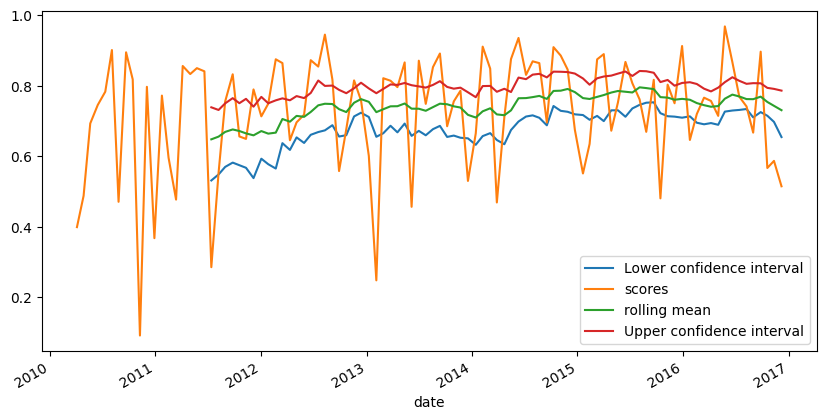

In [48]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label='Lower confidence interval')
scores_series.plot(ax=ax, label='scores')
scores_series.rolling(20).mean().plot(ax=ax, label='rolling mean')
scores_hi.plot(ax=ax, label='Upper confidence interval')
ax.legend()

You plotted a rolling confidence interval for scores over time. This is useful in seeing when your model predictions are correct.

### Accounting for non-stationarity
  
In this exercise, you will again visualize the variations in model scores, but now for data that changes its statistics over time.
  
An instance of the linear regression model object is stored in model, a cross-validation object in cv, and the data in X and y.
  
1. Create an empty DataFrame to collect the results.
2. Iterate through multiple window sizes, each time creating a new `TimeSeriesSplit` object.
3. Calculate the cross-validated scores (using a custom scorer we defined for you, `my_pearsonr`) of the model on training data.
4. Run the given code to plot the results.

In [49]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

[Text(0.5, 1.0, 'Scores for multiple windows'),
 Text(0, 0.5, 'Correlation (r)')]

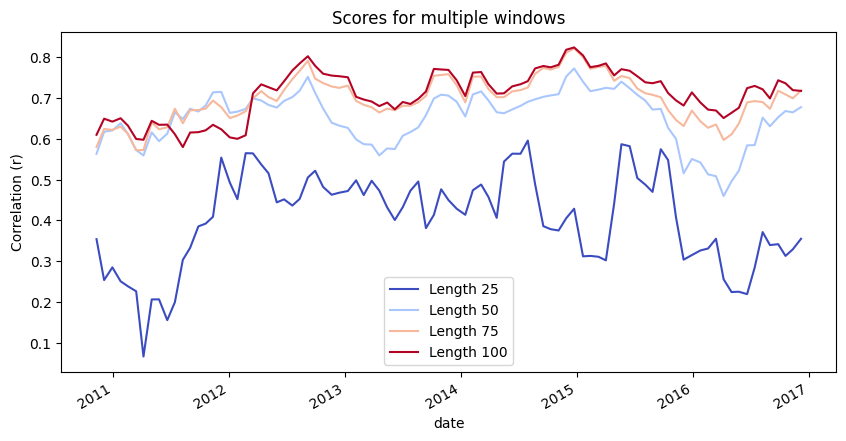

In [50]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')

Wonderful - notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.

## Wrapping-up
  
Now that you've gotten a taste of how time series and machine learning interact with each other, let's quickly recap what we covered in this course, and discuss where you can go next.
  
**Timeseries and machine learning**
  
The course started with a discussion of why it is useful to apply machine learning concepts to time series data, with a focus on classifying heartbeat sounds as normal and abnormal, as well as building predictive models of a company's value over time. We also emphasized the importance of visualizing and understanding your raw data.
  
**Feature extraction and classification**
  
We then turned to feature extraction and discussed how to collapse a time series array into a single summary statistic and combining many statistics of a time series into a single feature matrix that can be used to classify heartbeat sounds. We also discussed some advanced features that can only be calculated with time series data, such as the spectrogram.
  
**Model fitting and improving data quality**
  
We then covered generating model predictions that change over time by discussing a few regression features that are useful for this, such as creating time-shifted versions of an input. We used this in combination with techniques to clean and prepare our data in order to fit the best models.
  
**Validating and assessing our model performance**
  
Finally, we covered how to validate machine learning models with time series data. We covered some tips for doing cross-validation with time series data, and introduced a cross-validation iterator that is unique to time series data. We also discussed the importance of assessing if your time series is stationary, and showed a few ways to calculate and visualize your model's stability over subsets of the data.
  
**Advanced concepts in time series**
  
If you'd like to learn more about time series data in general, here are some topics worth investigating further. Advanced window functions can improve the "rolling window" statistics we calculated in this course. They're related to advanced signal processing techniques which will help you manipulate your time series data more effectively. Finally, we only barely touched the surface of spectral analysis, which is a complicated and quite interesting field.
  
**Advanced machine learning**
  
There are also many more topics to investigate in machine learning for time-series. There are many more features that can be extracted for modeling time-series. One useful Python package is `tsfresh`, which can calculate dozens of features from time series. We also only discussed a few specific models in classification and regression, but there is a wide range of other models that are suited for time series predictions. Finally, we only worked with pre-collected data that all fits into the computer's memory, but "real world" applications usually involve more complex processing and machine learning pipelines.
  
**Ways to practice**
  
If you'd like to practice your skills in machine learning with time-series, there are many options out there for you to experiment. For example, Kaggle has many curated time-series datasets with information about how they were collected, and community code snippets for models that have been fit. In addition, Quantopian runs a public service that lets users play around with financial data and build models that attempt to predict future values. It also has a large community of enthusiasts who learn and share their machine learning skills together.